## LSTM with average trajectories from the dataset

In [125]:
import numpy as np
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import math
import random

def pad(data):
    """
    pad data with np.nan (for data that is a list of arrays of different sizes).
    """
    
    x = len(data)
    y = max(len(arr) for arr in data)
    padded_data = np.full((x, y), np.nan)
    for i in range(x):
        padded_data[i, :len(data[i])] = data[i]
    return padded_data

def pad_2(data):
    """
    Pad a list of 2-column arrays (shape = [L_i, 2]) with np.nan 
    so they become a single array of shape (N, max_len, 2).
    """
    N = len(data)
    max_len = max(arr.shape[0] for arr in data)   # longest trajectory
    D = data[0].shape[1]                          # should be 2
    
    padded_data = np.full((N, max_len, D), np.nan)
    
    for i, arr in enumerate(data):
        length = arr.shape[0]
        padded_data[i, :length, :] = arr
    
    return padded_data

def contribution_threshold(data, cutoff_fraction):
    """
    Find the time index where certain fraction of the trajectories contribute.
    Basically, some random walkers will get stuck at a site for a long time and overshoot t_max
    by a lot. So time points will only have a few trajectories contributing to the ensemble average, 
    making it not a good statistical average/too small of a sample size.
    """
    data_arr = np.array(data)
    n_trajectories = data_arr.shape[0]
    min_required = int(cutoff_fraction * n_trajectories)  
    valid_counts = np.sum(~np.isnan(data), axis=0)
    cutoff_idx = np.where(valid_counts < min_required)[0]
    if len(cutoff_idx) > 0:
        last_valid_idx = cutoff_idx[0]
    else:
        last_valid_idx = data_arr.shape[1]
        
    return last_valid_idx


def average_trajectories(trajectories, t_max):
    """
    Carefully calculate averages of different variables over different random walkers 
    and different lattice configurations. 
    This is nontrivial since each random walker hops at different time points.
    """
    
    all_squared_displacements = [traj['sq_disp'] for traj in trajectories]
    all_times = [traj['times'] for traj in trajectories]
    all_distinct_sites = [traj['distinct_sites'] for traj in trajectories]

    #MSD vs steps
    padded_disp = pad(all_squared_displacements)
    msd_vs_steps = np.nanmean(padded_disp, axis=0)
    last_valid_idx = contribution_threshold(padded_disp, 0.8)
    msd_vs_steps = msd_vs_steps[:last_valid_idx]

    #MSD vs time
    from scipy.interpolate import interp1d

    t_bins = np.linspace(0, t_max, last_valid_idx)
    all_interp_disp = []
    for times, sq_disp in zip(all_times, all_squared_displacements):
        times = np.array(times)
        sq_disp = np.array(sq_disp)
        valid_mask = times <= t_max
        f = interp1d(times[valid_mask], sq_disp[valid_mask],
                     kind='previous', bounds_error=False, fill_value=np.nan)
        interp_disp = f(t_bins)
        all_interp_disp.append(interp_disp)

    msd_vs_time = np.nanmean(all_interp_disp, axis=0)
    last_valid_idx_time = contribution_threshold(all_interp_disp, 0.8)
    t_bins = t_bins[:last_valid_idx_time]
    msd_vs_time = msd_vs_time[:last_valid_idx_time]

    #Distinct sites visited vs steps
    padded_distinct_sites = pad(all_distinct_sites)
    distinct_sites_vs_steps = np.nanmean(padded_distinct_sites, axis=0)
    last_valid_idx_sites = contribution_threshold(padded_distinct_sites, 0.8)
    distinct_sites_vs_steps = distinct_sites_vs_steps[:last_valid_idx_sites]

    return msd_vs_steps, msd_vs_time, t_bins, distinct_sites_vs_steps




In [126]:
def build_features_for_trajectory(trajectories, t_max, seq_len, add_derivative=False):
    """
    Return features shape (seq_len, n_features) for one trajectory.
    Features: sq_disp, distinct_sites (and optional derivative of sq_disp).
    """
    seq_sq = trajectories['sq_disp']
    seq_sites =trajectories['distinct_sites']
    features = [seq_sq, seq_sites]
    # stack features -> (seq_len, n_features)
    feat = np.vstack(features).T.astype(np.float32)
    return feat

def build_dataset_from_trajectories(trajectories, labels, t_max=150.0, seq_len=200):
    """
    trajectories: list of dicts
    labels: dict with keys 'lattice', 'p', 'longrange' each a list/array of ints aligned with trajectories
    Returns: X (N, seq_len, n_features), y1,y2,y3 (N,)
    """
    N = len(trajectories)
    y1 = np.array(labels['lattice'], dtype=np.int64)
    y2 = np.array(labels['p'], dtype=np.int64)
    y3 = np.array(labels['longrange'], dtype=np.int64)
    X = [build_features_for_trajectory(traj,t_max, seq_len) for traj in trajectories]
    return X, y1, y2, y3

In [127]:
t_max = 150.0
seq_len = 200
trajectories = []
labels = {'lattice':[], 'conc':[], 'coupling':[]}

import os
import re
import numpy as np
import pandas as pd

data_folder = r"C:\Users\Ke\Documents\GithubRepo\Project_3_Physics188_288\Data"

pattern = re.compile(
    r"(?P<lat>BCC|diamond|FCC|SC)_p=(?P<p>\d+)%_(?P<int>alpha=6|nearestneighbor)\.npz"
)

records = []
data_list = []

for fname in os.listdir(data_folder):
    match = pattern.match(fname)
    if not match:
        print("Skipping invalid file:", fname)
        continue
    
    lattice_str = match.group("lat")
    if lattice_str == "BCC":
        lattice = 0
    elif lattice_str =="diamond":
        lattice = 1
    elif lattice_str == "FCC":
        lattice = 2
    else: # "SC"
        lattice = 3  # unknown

    p = float(match.group("p")) / 100.0
    
    longrange_str = match.group("int")

    longrange = 1 if longrange_str == "alpha=6" else 0

    file_path = os.path.join(data_folder, fname)
    data = np.load(file_path, allow_pickle=True)

    results = data['results']

    # divide the trajectories data into different block and average over each block, make sure block_size \times num_blocks = 10,000
    block_size = 100
    num_blocks = 100

    for i in range(num_blocks):
        start = i * block_size
        end = (i + 1) * block_size
        trajectories_temp = results[start:end]
        # results = data[list(data.keys())[0]]
        msd_vs_steps, msd_vs_time, t_bins, distinct_sites_vs_steps = average_trajectories(trajectories_temp, t_max)
        n_steps = np.arange(0, len(msd_vs_steps))
        # print(len(distinct_sites_vs_steps))

        trajectories.append({'steps':n_steps, 'sq_disp':msd_vs_steps, 'distinct_sites':distinct_sites_vs_steps})
        records.append({
            "filename": fname,
            "lattice": lattice,
            "p": p,
            "longrange": longrange
        })
labels = pd.DataFrame(records)



C:\Users\Ke\AppData\Local\Temp\ipykernel_16676\4278322791.py:92: RuntimeWarning: Mean of empty slice
  msd_vs_time = np.nanmean(all_interp_disp, axis=0)


Skipping invalid file: README.md
Skipping invalid file: test


In [128]:
import numpy as np
from keras import optimizers
from keras.layers import LSTM, Dense, Dropout, Masking
from keras.models import Sequential
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input
from keras.callbacks import EarlyStopping

# ============================================================
# VARIABLE-LENGTH DATA
# ============================================================

num_samples = 3200
F = 2
num_outputs = 3     # because y.shape = (N, 3)

X_list, y1, y2, y3 = build_dataset_from_trajectories(trajectories, labels, t_max=t_max, seq_len=seq_len)
y = np.stack([y1, y2, y3], axis=1)

# ============================================================
# FEATURE-WISE MINMAX SCALING
# ============================================================

scaler = MinMaxScaler()

X_concat = np.vstack(X_list)
X_scaled = scaler.fit_transform(X_concat)

X_list_scaled = []
idx = 0
for seq in X_list:
    Ti = seq.shape[0]
    X_list_scaled.append(X_scaled[idx:idx+Ti])
    idx += Ti

# ============================================================
# PADDING
# ============================================================

max_len = max(seq.shape[0] for seq in X_list_scaled)

X_padded = pad_sequences(
    X_list_scaled,
    maxlen=max_len,
    dtype="float32",
    padding="post",
    truncating="post",
    value=0.0
)

print("Padded X:", X_padded.shape)




# ============================================================
# TRAIN / VALIDATION SPLIT
# ============================================================

y1_original = y[:, 0] # 4 Class
y2_original = y[:, 1].reshape(-1, 1) # Regression
y3_original = y[:, 2].reshape(-1, 1) # Two Class
y1_onehot = to_categorical(y1_original, num_classes=4)

X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val = train_test_split( X_padded, y1_onehot, y2_original, y3_original, test_size=0.1, random_state=42 ) 
print(f"X_train shape: {X_train.shape}") 
print(f"y1_train shape (4 Class): {y1_train.shape}") 
print(f"y2_train shape (Regression): {y2_train.shape}") 
print(f"y3_train shape (Two Class): {y3_train.shape}")


# ============================================================
# TRAIN MODEL
# ============================================================


input_tensor = Input(shape=(max_len, F)) 
x = Masking(mask_value=0.0)(input_tensor) 
# x = LSTM(64, return_sequences=True)(x) 
# x = Dropout(0.3)(x) 
x = LSTM(32)(x)
output_y1 = Dense(4, activation='softmax', name='y1_classifier')(x) 
output_y2 = Dense(1, activation='relu', name='y2_regressor')(x) 
output_y3 = Dense(1, activation='sigmoid', name='y3_binary')(x) 
model = Model(inputs=input_tensor, outputs=[output_y1, output_y2, output_y3])
optimizer = optimizers.Adam(learning_rate=1e-3) 
model.compile( optimizer=optimizer, 
                loss={ 'y1_classifier': 'categorical_crossentropy',
                    'y2_regressor': 'mse',
                    'y3_binary': 'binary_crossentropy'        
                    }, 
                metrics={ 'y1_classifier': ['accuracy'], 'y2_regressor': ['mae'], 'y3_binary': ['accuracy'] } )
model.summary()

early_stopping = EarlyStopping( monitor='val_loss',
                               patience=5,
                               restore_best_weights=True, verbose=1 ) 
history = model.fit( X_train, 
                    [y1_train, y2_train, y3_train], 
                    validation_data=(X_val, [y1_val, y2_val, y3_val]), 
                    epochs=100, 
                    batch_size=32, verbose=1, callbacks=[early_stopping] )



Padded X: (3200, 236, 2)
X_train shape: (2880, 236, 2)
y1_train shape (4 Class): (2880, 4)
y2_train shape (Regression): (2880, 1)
y3_train shape (Two Class): (2880, 1)


Model: "functional_188"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 236, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_190       │ (None, 236, 2)    │          0 │ input_layer_55[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_55          │ (None, 236, 2)    │          0 │ input_layer_55[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_190 (Any)       │ (None, 236)       │          0 │ not_equal_190[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_78 (LSTM)      │ (None, 32)        │      4,480 │ masking_55[0][0], │
│                     │                   │            │ any_190[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_classifier       │ (None, 4)         │        132 │ lstm_78[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_regressor        │ (None, 1)         │         33 │ lstm_78[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y3_binary (Dense)   │ (None, 1)         │         33 │ lstm_78[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,678 (18.27 KB)

 Trainable params: 4,678 (18.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 2.0843 - y1_classifier_accuracy: 0.3601 - y1_classifier_loss: 1.3107 - y2_regressor_loss: 0.1678 - y2_regressor_mae: 0.3285 - y3_binary_accuracy: 0.7427 - y3_binary_loss: 0.6058 - val_loss: 1.8119 - val_y1_classifier_accuracy: 0.4781 - val_y1_classifier_loss: 1.1918 - val_y2_regressor_loss: 0.1481 - val_y2_regressor_mae: 0.3188 - val_y3_binary_accuracy: 0.8281 - val_y3_binary_loss: 0.4720
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.7649 - y1_classifier_accuracy: 0.4993 - y1_classifier_loss: 1.0904 - y2_regressor_loss: 0.1508 - y2_regressor_mae: 0.3130 - y3_binary_accuracy: 0.7795 - y3_binary_loss: 0.5238 - val_loss: 1.6240 - val_y1_classifier_accuracy: 0.4406 - val_y1_classifier_loss: 1.0133 - val_y2_regressor_loss: 0.1447 - val_y2_regressor_mae: 0.3110 - val_y3_binary_accuracy: 0.8156 - val_y3_binary_loss: 0.4661
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5876 - y1_classifier_accuracy: 0.5

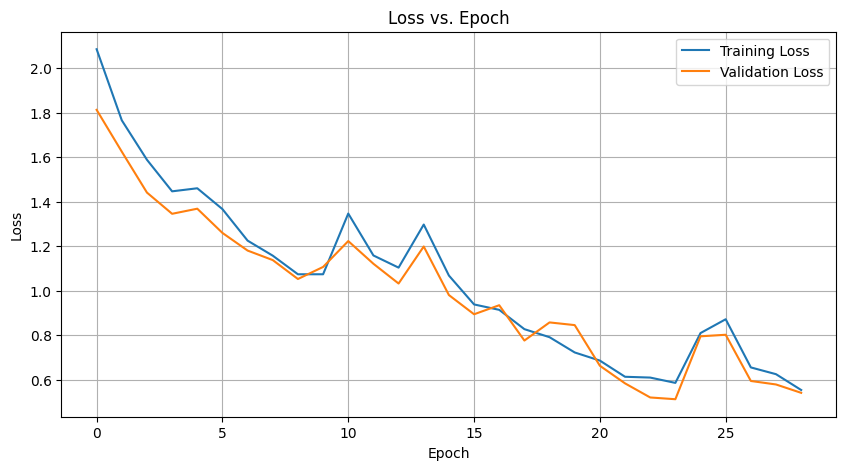

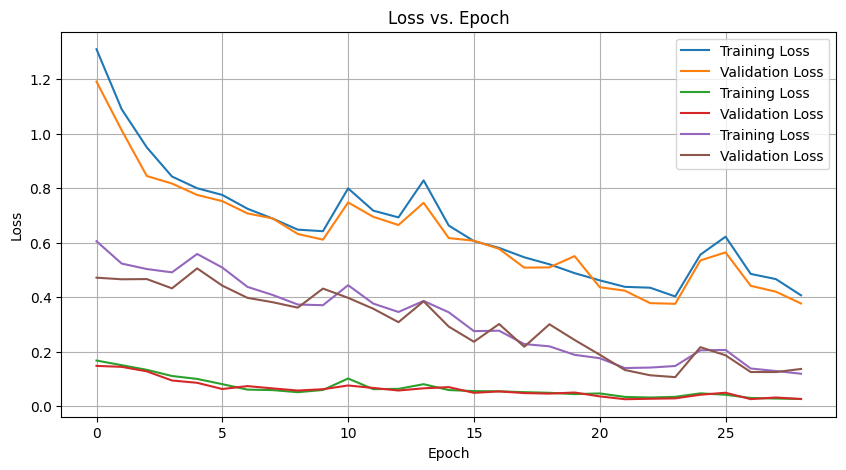

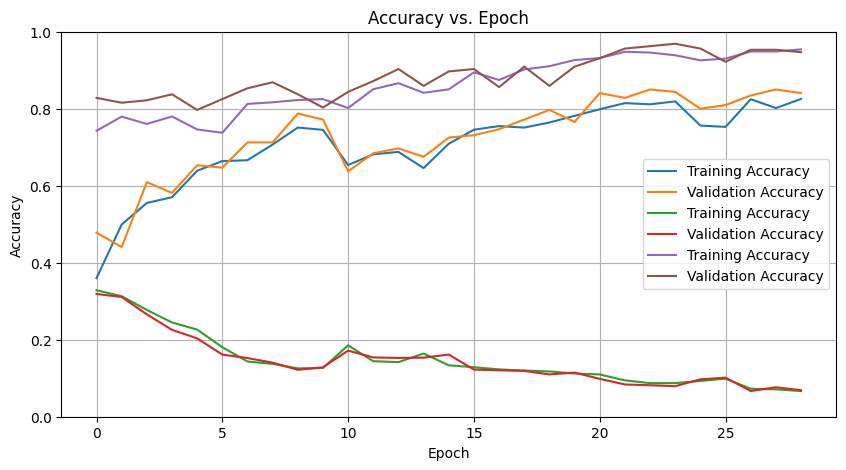


Model saved as lstm_multilabel_multiend_classifier2.h5


In [129]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['y1_classifier_loss'], label='Training Loss')
plt.plot(history.history['val_y1_classifier_loss'], label='Validation Loss')

plt.plot(history.history['y2_regressor_loss'], label='Training Loss')
plt.plot(history.history['val_y2_regressor_loss'], label='Validation Loss')

plt.plot(history.history['y3_binary_loss'], label='Training Loss')
plt.plot(history.history['val_y3_binary_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['y1_classifier_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_y1_classifier_accuracy'], label='Validation Accuracy')

plt.plot(history.history['y2_regressor_mae'], label='Training Accuracy')
plt.plot(history.history['val_y2_regressor_mae'], label='Validation Accuracy')

plt.plot(history.history['y3_binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_y3_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.show()



model.save("lstm_multilabel_multiend_classifier2.h5")
np.save("scaler_minmax2.npy", scaler.data_min_)
print("\nModel saved as lstm_multilabel_multiend_classifier2.h5")

In [130]:
import numpy as np
from keras import optimizers
from keras.layers import LSTM, Dense, Dropout, Masking
from keras.models import Sequential
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input
from keras.callbacks import EarlyStopping

# ============================================================
# VARIABLE-LENGTH DATA
# ============================================================

num_samples = 3200
F = 2
num_outputs = 3     # because y.shape = (N, 3)

X_list, y1, y2, y3 = build_dataset_from_trajectories(trajectories, labels, t_max=t_max, seq_len=seq_len)
y = np.stack([y1, y2, y3], axis=1)

# ============================================================
# FEATURE-WISE MINMAX SCALING
# ============================================================

scaler = MinMaxScaler()

X_concat = np.vstack(X_list)
X_scaled = scaler.fit_transform(X_concat)

X_list_scaled = []
idx = 0
for seq in X_list:
    Ti = seq.shape[0]
    X_list_scaled.append(X_scaled[idx:idx+Ti])
    idx += Ti

# ============================================================
# PADDING
# ============================================================

max_len = max(seq.shape[0] for seq in X_list_scaled)

X_padded = pad_sequences(
    X_list_scaled,
    maxlen=max_len,
    dtype="float32",
    padding="post",
    truncating="post",
    value=0.0
)

print("Padded X:", X_padded.shape)



# ============================================================
# TRAIN / VALIDATION SPLIT
# ============================================================

y1_original = y[:, 0] # 4 Class
y2_original = y[:, 1].reshape(-1, 1) # Regression
y3_original = y[:, 2].reshape(-1, 1) # Two Class
y1_onehot = to_categorical(y1_original, num_classes=4)

X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val = train_test_split( X_padded, y1_onehot, y2_original, y3_original, test_size=0.1, random_state=42 ) 
print(f"X_train shape: {X_train.shape}") 
print(f"y1_train shape (4 Class): {y1_train.shape}") 
print(f"y2_train shape (Regression): {y2_train.shape}") 
print(f"y3_train shape (Two Class): {y3_train.shape}")


# ============================================================
# TRAIN MODEL
# ============================================================


input_tensor = Input(shape=(max_len, F)) 
x = Masking(mask_value=0.0)(input_tensor) 
x = LSTM(64, return_sequences=True)(x) 
x = Dropout(0.3)(x) 
x = LSTM(32)(x) 


output_y1 = Dense(4, activation='softmax', name='y1_classifier')(x) 
output_y2 = Dense(1, activation='relu', name='y2_regressor')(x) 
output_y3 = Dense(1, activation='sigmoid', name='y3_binary')(x) 
model = Model(inputs=input_tensor, outputs=[output_y1, output_y2, output_y3])
optimizer = optimizers.Adam(learning_rate=1e-3) 
model.compile( optimizer=optimizer, 
                loss={ 'y1_classifier': 'categorical_crossentropy', 
                    'y2_regressor': 'mse', 
                    'y3_binary': 'binary_crossentropy'          
                    },
                metrics={ 'y1_classifier': ['accuracy'], 'y2_regressor': ['mae'], 'y3_binary': ['accuracy'] } )
model.summary()
early_stopping = EarlyStopping( monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, verbose=1 ) 
history = model.fit( X_train,
                    [y1_train, y2_train, y3_train], 
                    validation_data=(X_val, [y1_val, y2_val, y3_val]), 
                    epochs=100, 
                    batch_size=32, verbose=1, callbacks=[early_stopping] )



Padded X: (3200, 236, 2)
X_train shape: (2880, 236, 2)
y1_train shape (4 Class): (2880, 4)
y2_train shape (Regression): (2880, 1)
y3_train shape (Two Class): (2880, 1)


Model: "functional_189"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_56      │ (None, 236, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_191       │ (None, 236, 2)    │          0 │ input_layer_56[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_56          │ (None, 236, 2)    │          0 │ input_layer_56[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_191 (Any)       │ (None, 236)       │          0 │ not_equal_191[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_79 (LSTM)      │ (None, 236, 64)   │     17,152 │ masking_56[0][0], │
│                     │                   │            │ any_191[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 236, 64)   │          0 │ lstm_79[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ (None, 32)        │     12,416 │ dropout_24[0][0], │
│                     │                   │            │ any_191[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1_classifier       │ (None, 4)         │        132 │ lstm_80[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y2_regressor        │ (None, 1)         │         33 │ lstm_80[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y3_binary (Dense)   │ (None, 1)         │         33 │ lstm_80[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,766 (116.27 KB)

 Trainable params: 29,766 (116.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 1.9654 - y1_classifier_accuracy: 0.4194 - y1_classifier_loss: 1.2431 - y2_regressor_loss: 0.1733 - y2_regressor_mae: 0.3254 - y3_binary_accuracy: 0.7635 - y3_binary_loss: 0.5490 - val_loss: 1.5955 - val_y1_classifier_accuracy: 0.5844 - val_y1_classifier_loss: 1.0171 - val_y2_regressor_loss: 0.1685 - val_y2_regressor_mae: 0.3030 - val_y3_binary_accuracy: 0.8438 - val_y3_binary_loss: 0.4099
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 1.4442 - y1_classifier_accuracy: 0.5979 - y1_classifier_loss: 0.8801 - y2_regressor_loss: 0.1157 - y2_regressor_mae: 0.2397 - y3_binary_accuracy: 0.8038 - y3_binary_loss: 0.4484 - val_loss: 1.2922 - val_y1_classifier_accuracy: 0.6250 - val_y1_classifier_loss: 0.7809 - val_y2_regressor_loss: 0.0894 - val_y2_regressor_mae: 0.2117 - val_y3_binary_accuracy: 0.7937 - val_y3_binary_loss: 0.4219
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 1.2494 - y1_classifier_accurac

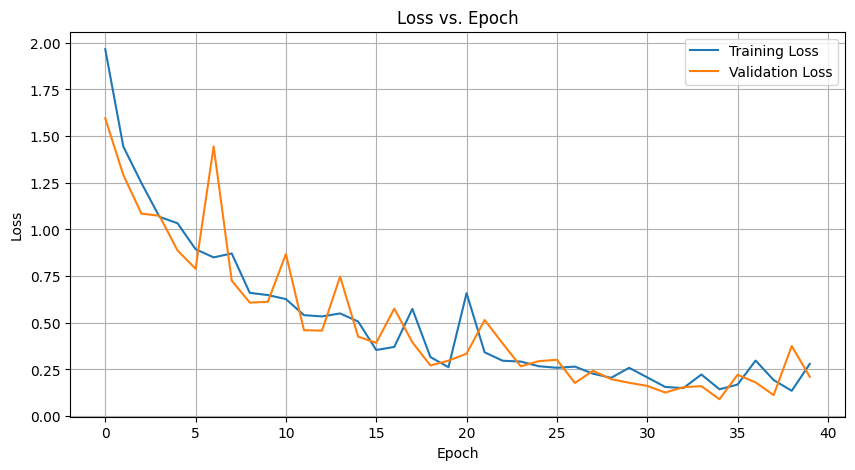

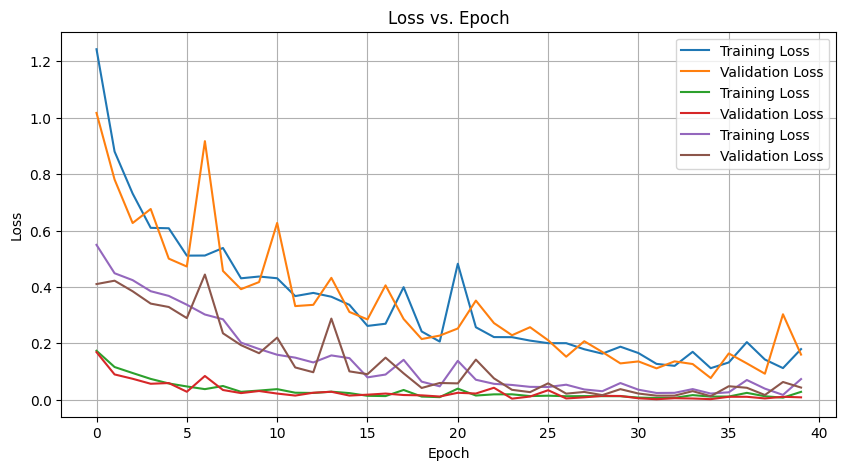

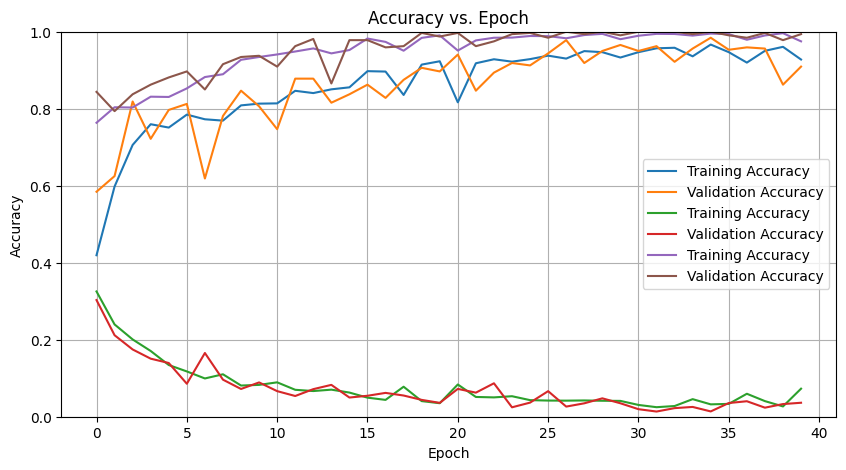


Model saved as lstm_multilabel_multiend_classifier2.h5


In [131]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['y1_classifier_loss'], label='Training Loss')
plt.plot(history.history['val_y1_classifier_loss'], label='Validation Loss')

plt.plot(history.history['y2_regressor_loss'], label='Training Loss')
plt.plot(history.history['val_y2_regressor_loss'], label='Validation Loss')

plt.plot(history.history['y3_binary_loss'], label='Training Loss')
plt.plot(history.history['val_y3_binary_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['y1_classifier_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_y1_classifier_accuracy'], label='Validation Accuracy')

plt.plot(history.history['y2_regressor_mae'], label='Training Accuracy')
plt.plot(history.history['val_y2_regressor_mae'], label='Validation Accuracy')

plt.plot(history.history['y3_binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_y3_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()
plt.grid(True)
plt.show()



model.save("lstm_multilabel_multiend_classifier2.h5")
np.save("scaler_minmax2.npy", scaler.data_min_)
print("\nModel saved as lstm_multilabel_multiend_classifier2.h5")